In [108]:
from segment_image import *
from skimage.transform import hough_line, hough_line_peaks
from tqdm import tqdm
import pickle
from scipy import stats

In [148]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

In [3]:
def potential_staff_lines(note_img_thresh, staff_thickness):
    DEG_TO_RAD = np.pi/180
    width = note_img_thresh.shape[1]

    # Hough to get potential staff lines
    line_length = int(width/4)
    lines = probabilistic_hough_line(note_img_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=40)
    lines_img_before_filteration = draw_hough_lines(lines, note_img_thresh.shape, 1)
    lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))

    # Get widest 5 contours/lines
    lines_img = np.copy(lines_img_before_filteration)
    image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_bounding_rectangles = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        #print(x, y, w, h)
        contours_bounding_rectangles.append([c, [x, y, w, h]])

    contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
    contours_widest_5 = []
    j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
    for i in range(j):
        contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])

    # Draw widest 5 contours/lines
    lines_img = np.zeros(note_img_thresh.shape, dtype=np.uint8)
    lines_img = cv2.cvtColor(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1), cv2.COLOR_BGR2GRAY)
    k = 3
    lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))
    lines_img = cv2.dilate(lines_img, np.ones((3, 3)))

    # my_show_images([lines_img])

    return lines_img

In [4]:
def remove_staff_lines(note_img_gray):
    # Otsu's thresholding
    ret, note_img_thresh = cv2.threshold(note_img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    _distance_between_staves, _staff_thickness = get_distance_between_staves_and_staff_thickness(note_img_thresh)

    note_img_thresh = 255-note_img_thresh

    # Potential staff lines
    potential_lines_img = potential_staff_lines(note_img_thresh, _staff_thickness)
    lines_img_flattened = (potential_lines_img > 128).T.flatten()
    
    # Iterate over each column to remove any "run of white pixels" with a length of "m*_staff_thickness"
    # But it must be a part from a potentail line to confirm removing (potential lines calculated above)
    note_img_thresh_flattened = (note_img_thresh).T.flatten()
    image, contours, hierarchy = cv2.findContours((note_img_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if c.shape == (2, 1, 2):
            p1 = c[1][0][1]
            p0 = c[0][0][1]
            m = 1.55
            if p1 - p0 <= _staff_thickness*m:
                #print(c)
                staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
                if staff_pixel_percentage > 0.35:
                    note_img_thresh_flattened[p0:p1+1] = 0
        elif c.shape == (1, 1, 2):
            #print(c)
            p0 = c[0][0][1]
            staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
            if staff_pixel_percentage > 0.35:
                note_img_thresh_flattened[p0:p0+1] = 0


    staff_lines_removed = note_img_thresh_flattened.reshape(note_img_thresh.T.shape).T
    #print(staff_lines_removed.max())

    #my_show_images([note_img_gray, note_img_thresh, potential_lines_img, staff_lines_removed], dpi=80, row_max=5)

    return staff_lines_removed, potential_lines_img, _distance_between_staves, _staff_thickness

In [136]:
def getNotes(original_img, img_thresh):

    #ori_img = io.imread(pathImage)

    width= original_img.shape[1]
    height = original_img.shape[0]

    #img_thresh = ori_img
    #show_images([img_thresh],["thresh"])

    hist = []

    # get Concentration Histogram
    for x in range(width):
        hist.append(sum(img_thresh[0:height,x] == 0))

    # find thr for detecting character
    counts = np.bincount(np.array(hist))
    thr_character = np.argmax(counts) * 1.1
    #thr_character = stats.mode(hist)



    #convert list of hist to numpy array as uint8 for  using in countours
    a = np.zeros(img_thresh.shape)
    arr = np.array(hist)
    a = a < ((arr > thr_character)*255)
    a = a.astype('uint8')

    #my_show_images([a])

    #a = cv2.dilate(a, np.ones((1, 27)))

    # using a that represnts hist list in countours
    contours, hierarchy = cv.findContours(a, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    listOfImages = []
   
    for contour in contours:

        x, y, w, h = cv.boundingRect(contour)
        start = x - 12
        start = max(0,start)
        end = x + w + 12
        end = min(end,width)
        out = original_img[y:y+h,start : end]
        listOfImages.append(out)
        
    return list(reversed(listOfImages))

In [6]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

In [7]:
def contours_mask(contours, shape):
    mask = cv2.cvtColor(np.zeros(shape[:2], dtype=np.uint8), cv2.COLOR_GRAY2BGR)
    mask = cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [453]:
def zoom_in(staff_lines_removed, potential_staff_lines):
    notes_masked_only = []
    notes_zoomed_in = []
    staff_lines = []
    notes_contours = []


    staff_lines_removed = np.ascontiguousarray(staff_lines_removed)
    test_copy = cv2.dilate(staff_lines_removed, np.ones((5, 5)))
    #test_copy = staff_lines_removed

    image, contours, hierarchy = cv2.findContours(test_copy,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #contours_drawn = gray2rgb(np.copy(test_copy))
    contours_sorted_by_area = sorted(contours, key=cv2.contourArea, reverse=True)
    
    max_area_contour = contours_sorted_by_area[0]
    x, y, w, h = cv2.boundingRect(max_area_contour)
    a0 = w*h

    max_area_contour_mask = contours_mask([max_area_contour], staff_lines_removed.shape)
    #my_show_images([staff_lines_removed, max_area_contour_mask], dpi=80, row_max=2)
    masked_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128)))
    zoomed_in_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128))[y:y+h, x:x+w])
    
    if len(contours_sorted_by_area) == 1:
        # Append zoomed_in_biggest only
        notes_masked_only.append(masked_biggest)
        notes_zoomed_in.append(zoomed_in_biggest)
        staff_lines.append(potential_staff_lines)
        notes_contours.append(max_area_contour)
    else:
        second_max_area_contour = contours_sorted_by_area[1]
        x1, y1, w1, h1 = cv2.boundingRect(second_max_area_contour)
        a1 = w1*h1
        
        if a1 / a0 > 0.4:
            second_max_area_contour_mask = contours_mask([second_max_area_contour], staff_lines_removed.shape)
            masked_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128)))
            zoomed_in_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128))[y1:y1+h1, x1:x1+w1])

            # Append zoomed_in_biggest & zoomed_in_second_biggest in correct order
            if x > x1:
                # Append zoomed_in_biggest first
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(max_area_contour)

                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(second_max_area_contour)
            else:
                # Append zoomed_in_biggest second
                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(second_max_area_contour)
                
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(max_area_contour)
        else:
            # Append zoomed_in_biggest only
            notes_masked_only.append(masked_biggest)
            notes_zoomed_in.append(zoomed_in_biggest)
            staff_lines.append(potential_staff_lines)
            notes_contours.append(max_area_contour)

    #print(len(notes_masked_only), len(notes_zoomed_in), len(staff_lines), len(notes_contours))
    return notes_masked_only, notes_zoomed_in, staff_lines, notes_contours

In [471]:
def get_note_heads_contours(staff_lines_removed_masked, distance_between_staves, staff_thickness):
    #thresh = cv2.adaptiveThreshold(255-staff_lines_removed_masked, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)
    _thresh = cv2.Canny(staff_lines_removed_masked, 100, 200)
    structuring_element_size = int(round(staff_thickness*6))
    thresh = my_close(_thresh, np.ones((structuring_element_size, structuring_element_size)))
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    '''my_area = thresh.shape[0]*thresh.shape[0]
    contours_filtered = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        a = w*h
        print(a/my_area)
        if 0.003 < a/my_area < 0.025: # test 1
            if x > 0 and x+w < thresh.shape[1]: # test 2
                (xc,yc), (d1,d2), angle = cv2.fitEllipse(c)
                major_axis, minor_axis = max(d1,d2), min(d1,d2)
                if major_axis/minor_axis <= 2.2: # test 3
                    epsilon = 0.02*cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, epsilon, True)
                    if len(approx) > 4: # test 4
                        contours_filtered.append(c)'''

    my_area = np.pi/4 * distance_between_staves**2
    contours_filtered = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        a = cv2.contourArea(c)
        #print(a, my_area)
        if my_area*0.5 < a < my_area*3: # test 1
            if len(c)<5 :     #added edris
                continue #added edris
            (xc,yc), (d1,d2), angle = cv2.fitEllipse(c) # todo fix error : There should be at least 5 points to fit the ellipse in function 'cv::fitEllipse'
            major_axis, minor_axis = max(d1,d2), min(d1,d2)
            if major_axis/minor_axis <= 2.2: # test 2
                (xc, yc),radius = cv2.minEnclosingCircle(c)
                mec_area = np.pi * radius**2
                print(a/mec_area)
                if a/mec_area > 0.47:
                    epsilon = 0.02*cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, epsilon, True)
                    if len(approx) > 4: # test 4
                        contours_filtered.append(c)
                #if x > 0 and x+w < thresh.shape[1]: # test 3
            
                

    contours_drawn = gray2rgb(np.copy(thresh))
    contours_drawn = cv2.drawContours(contours_drawn, contours_filtered, -1, (255, 0, 0), 2)
    #contours_drawn = cv2.drawContours(contours_drawn, contours[2], -1, (255, 0, 0), 2)


    #mask = cv2.dilate(contours_mask(contours_filtered, thresh.shape), np.ones((3, 3)))
    mask = contours_mask(contours_filtered, thresh.shape)
    image, contours_final, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours_final))

    my_show_images([_thresh, thresh, contours_drawn, mask], dpi=80, row_max=4)
    return contours_final

### Classifier functions

In [10]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [11]:
def extract_features(img, feature_set='hog'):
    """
    TODO
    Given either 'hog', 'raw', call the respective function and return its output
    """
    if feature_set == 'hog':
        return extract_hog_features(img)
    elif feature_set == 'raw':
        return extract_raw_pixels(img)

In [12]:
def extract_features_for_all(imgs, feature_set='hog'):
    features = []

    for i, img in enumerate(tqdm(imgs)):
        try:
            features.append(extract_features(img, feature_set))
        except:
            print(img)
            del labels[i]
    
    return features

## identify note letter

In [473]:
def get_letter(staff_lines_img_original, note_contour, distance_between_stave, is_upper):
    x, y, w, h = cv2.boundingRect(note_contour)
    #print(str(x+w)+" vv "+str(y+h))

    staff_lines_img = staff_lines_img_original > 0
    middle = round(x + w/2)
    #height = staff_lines_img.shape[1]
    
    middle_column = (staff_lines_img[:, middle-1:middle+2]*255).astype(np.uint8)

    _, contours, _ = cv2.findContours(middle_column, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0: 
        return ''
    max_area_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_area_contour)

    ds = h/4 #distance_between_staves
    print(ds, distance_between_stave)
    distance_between_stave = ds
    stave_height_list = [int(y), int(y+ds), int(y+2*ds), int(y+3*ds), int(y+4*ds)]
    
    '''_staff_lines_img_original_ = cv2.cvtColor(np.copy(staff_lines_img_original), cv2.COLOR_GRAY2BGR)
    _staff_lines_img_original_[stave_height_list[0], :] = [255, 0, 0]
    _staff_lines_img_original_[stave_height_list[1], :] = [255, 0, 0]
    _staff_lines_img_original_[stave_height_list[2], :] = [255, 0, 0]
    _staff_lines_img_original_[stave_height_list[3], :] = [255, 0, 0]
    _staff_lines_img_original_[stave_height_list[4], :] = [255, 0, 0]

    my_show_images([_staff_lines_img_original_], dpi=100)'''


   
    '''last_taken = False
    start_of_line = -1
    array_of_lines =  []
    for i in range(len(middle_column)):
        if(start_of_line!=-1 and middle_column[i]!=1):
            array_of_lines.append((start_of_line+i-1)//2)
            start_of_line = -1
            continue
        
        if(middle_column[i]==1 and start_of_line==-1):
            start_of_line = i 
            continue
        
    
    for i in range(5):
        if(i>=len(array_of_lines)):
            break
        stave_height_list[i]  = array_of_lines[i]
    
    #print(stave_height_list)'''
    note_place = 0 

    x, y, w, h = cv2.boundingRect(note_contour)
    
    if(is_upper):
        note_place = y + distance_between_stave/2
    else:
        note_place = y + h - distance_between_stave/2
    
    
    notes = {
        "c1" : stave_height_list[4]+distance_between_stave,
        "d1" : stave_height_list[4]+distance_between_stave/2 ,
        "e1" : stave_height_list[4],
        "f1" : stave_height_list[3]+distance_between_stave/2,
        "g1" : stave_height_list[3],
        "a1" : stave_height_list[2]+distance_between_stave/2,
        "b1" : stave_height_list[2] ,
        
        "c2" : stave_height_list[1]+distance_between_stave/2 ,
        "d2" : stave_height_list[1] ,
        "e2" : stave_height_list[0]+distance_between_stave/2 ,
        "f2" : stave_height_list[0] ,
        "g2" : stave_height_list[0]-distance_between_stave/2  ,
        "a2" : stave_height_list[0]-distance_between_stave      
    }
    '''notes = {
    "c1" : stave_height_list[4]+distance_between_stave,
    "d1" : stave_height_list[4]+distance_between_stave/2 ,
    "e1" : stave_height_list[4],
    "f1" : (stave_height_list[3]+stave_height_list[4])/2,
    "g1" : stave_height_list[3],
    "a1" : (stave_height_list[2]+stave_height_list[3])/2,
    "b1" : stave_height_list[2] ,
    
    "c2" : (stave_height_list[1]+stave_height_list[2])/2 ,
    "d2" : stave_height_list[1] ,
    "e2" : (stave_height_list[0]+stave_height_list[1])/2 ,
    "f2" : stave_height_list[0] ,
    "g2" : stave_height_list[0]-distance_between_stave/2  ,
    "a2" : stave_height_list[0]-distance_between_stave      
    }'''
    min_dist = 10000000
    note = "a1"
    for key, value in notes.items():
        distance = abs(note_place-value)
        #print(key+"  "+str(distance))
        if distance < min_dist :
            min_dist = distance
            
            note = key
    
    
    #print("note place : "+str(note_place) +" note : "+note)
    return note

In [14]:
#print(distance_between_staves)
#kk = 10
#print(get_letter()
##174

#my_show_images([list_of_notes_classification_ready[0][kk],list_of_notes_staff_lines_classification_ready[0][kk]])

In [15]:
upper  = {
    "sixtheenth_note" : False ,
    "eighth_note" : False ,
    "thirty_second_note" : False ,
    "quarter_note" : False ,
    "half_note" : False ,
    "whole_note" : False,
    "sixtheenth_note_upside_down" : True ,
    "eighth_note_upside_down" : True ,
    "thirty_second_note_upside_down" : True ,
    "quarter_note_upside_down" : True ,
    "half_note_upside_down" : True 
}

check_for_char  = {
    "sixtheenth_note" : True ,
    "eighth_note" : True ,
    "thirty_second_note" : True ,
    "quarter_note" : True ,
    "half_note" : True ,
    "whole_note" : True,
    "sixtheenth_note_upside_down" : True ,
    "eighth_note_upside_down" : True ,
    "thirty_second_note_upside_down" : True ,
    "quarter_note_upside_down" : True ,
    "half_note_upside_down" : True,
    "augmentation_dot" :False ,
    "double_flat_accidental" :False ,
    "double_sharp_accidental" : False ,
    "flat_accidental":False ,
    "natural_accidental" :False,
    "sharp_accidental" : False ,
    "time_signature_4_2":False ,
    "time_signature_4_4": False,
    "treple_clef":False,
    
    "time_signature_2":False,
    "time_signature_4":False,
    "treple_clef_upside_down":False,
    "bar_line":False,
    "bar_line_thick":False,
    "augmentation_dot":False
    
    
}

corresponding_text  = {
    "sixtheenth_note" : "/16" ,
    "eighth_note" : "/8" ,
    "thirty_second_note" : "/32" ,
    "quarter_note" : "/4" ,
    "half_note" : "/2" ,
    "whole_note" : "/1",
    "sixtheenth_note_upside_down" :"/16" ,
    "eighth_note_upside_down" : "/8" ,
    "thirty_second_note_upside_down": "/32" ,
    "quarter_note_upside_down" :  "/4" ,
    "half_note_upside_down" : "/2" ,
    "augmentation_dot" :".",
    "double_flat_accidental" :"&&" ,
    "double_sharp_accidental" : "##" ,
    "flat_accidental":"&" ,
    "natural_accidental" : "",
    "sharp_accidental" : "#",
    "time_signature_4_2": "2",
    "time_signature_4_4": "4",
    "treple_clef":"",
    
    "augmentation_dot":".",
    
    "time_signature_2":"2",
    "time_signature_4":"4",
    "treple_clef_upside_down":"",
    "bar_line":"",
    "bar_line_thick":""
}

# Load our classifier

In [320]:
target_img_size = (32, 32)
with open('svm.pkl', 'rb') as fid:
    model = pickle.load(fid)

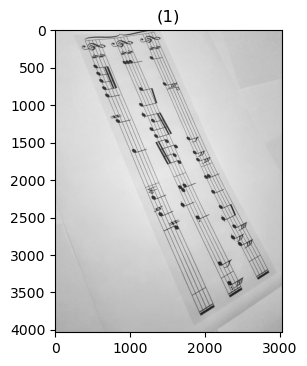

In [459]:
img = my_imread_gray('18.jpg')
my_show_images([img], dpi=100)

# Separate lines

In [460]:
gray_lines, binary_lines, distance_between_staves, staff_thickness = get_lines(img)

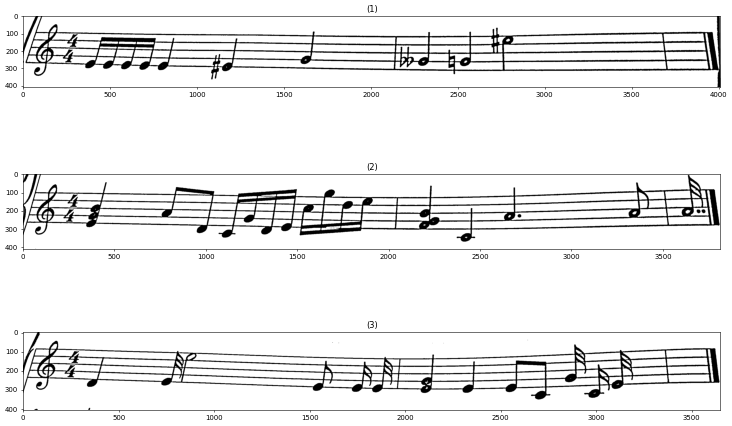

In [461]:
my_show_images(binary_lines, dpi=50)

# Shubra's potential_lines_of_notes 

In [462]:
potential_lines_of_notes = []
for _gray_line, _binary_line in zip(gray_lines, binary_lines):
    potential_lines_of_notes.append(getNotes(_gray_line, _binary_line))
    print('One iteration done ...')

One iteration done ...
One iteration done ...
One iteration done ...


# Removing staff lines

In [463]:
list_of_notes = []
list_of_notes_original_thresholded = []
list_of_notes_staff_lines = []
list_of_notes_staff_lines_d_t = []

for i, l in enumerate(potential_lines_of_notes):
    list_of_notes.append([])
    list_of_notes_staff_lines.append([])
    list_of_notes_staff_lines_d_t.append([])
    list_of_notes_original_thresholded.append([])
    
    for _note in l:
        if _note.shape[1] >= 25:
            staff_lines_removed, staff_lines, d, t = remove_staff_lines(_note)
            if (staff_lines_removed > 128).any():
                list_of_notes[i].append(staff_lines_removed)
                list_of_notes_staff_lines[i].append(staff_lines)
                list_of_notes_staff_lines_d_t[i].append((d, t))
                #otsu
                ret, note_img_thresh = cv2.threshold(_note, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

                list_of_notes_original_thresholded[i].append(255-note_img_thresh)

In [464]:
for i, l in enumerate(list_of_notes_original_thresholded):
    for j , _note in enumerate(l):
        list_of_notes_original_thresholded[i][j] = list_of_notes_original_thresholded[i][j] - list_of_notes[i][j]

#

In [465]:
for i, l in enumerate(list_of_notes_original_thresholded):
    for j , _note in enumerate(l):
        width = round(list_of_notes_original_thresholded[i][j].shape[1])
        list_of_notes_original_thresholded[i][j] = cv2.dilate(list_of_notes_original_thresholded[i][j], np.ones((1, width)))

        '''#my_show_images([list_of_notes_original_thresholded[i][j]], dpi=10, row_max=3)

        _, contours, _ = cv2.findContours(list_of_notes_original_thresholded[i][j], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        contours_as_wide_as_width = [c for c in contours if cv2.boundingRect(c)[2] == width]


        areas = np.array([cv2.contourArea(c) for c in contours_as_wide_as_width])
        #areas = np.array([cv2.contourArea(c) for c in contours_as_wide_as_width])
        median = np.median(areas)
        areas_median_diff = np.abs(areas - median)
        areas_median_diff_arg_sorted = np.argsort(areas_median_diff)
        #print(areas_median_diff_arg_sorted.shape)
        contours_filtered = []
        for iiii in range(5):
            if iiii >= len(contours_as_wide_as_width):
                break
            contours_filtered.append(contours_as_wide_as_width[areas_median_diff_arg_sorted[iiii]])

        contours_mask_staff = contours_mask(contours_filtered, list_of_notes_original_thresholded[i][j].shape)
        list_of_notes_staff_lines[i][j] = contours_mask_staff'''

        k = distance_between_staves*2
        #list_of_notes_original_thresholded[i][j] = my_close(list_of_notes_original_thresholded[i][j], np.ones((k, k)))
        list_of_notes_staff_lines[i][j] = my_close(list_of_notes_original_thresholded[i][j], np.ones((k, k)))
        
        #my_show_images([list_of_notes_original_thresholded[i][j], list_of_notes_staff_lines[i][j]], dpi=50, row_max=2)

        

In [466]:
'''kk = 1
my_show_images(list_of_notes[kk], dpi=80, row_max=10)
my_show_images(list_of_notes_staff_lines[kk], dpi=80, row_max=10)
my_show_images(list_of_notes_original_thresholded[kk], dpi=80, row_max=10)'''

'kk = 1\nmy_show_images(list_of_notes[kk], dpi=80, row_max=10)\nmy_show_images(list_of_notes_staff_lines[kk], dpi=80, row_max=10)\nmy_show_images(list_of_notes_original_thresholded[kk], dpi=80, row_max=10)'

# Zoom in

In [467]:
list_of_notes_masked = []
list_of_notes_classification_ready = [] # zoomed in + padding
list_of_notes_classification_ready_split_notes_i = [] # VIP when detecting an upside down treple clef
list_of_notes_staff_lines_classification_ready = []
list_of_notes_classification_ready_contours = []
list_of_notes_staff_lines_d_t_classification_ready=[]

i = 0
for line_of_notes, line_notes_staff_lines, notes_staff_lines_d_t in zip(list_of_notes, list_of_notes_staff_lines,list_of_notes_staff_lines_d_t):
    list_of_notes_masked.append([])
    list_of_notes_classification_ready.append([])
    list_of_notes_classification_ready_split_notes_i.append([])
    list_of_notes_staff_lines_classification_ready.append([])
    list_of_notes_classification_ready_contours.append([])
    list_of_notes_staff_lines_d_t_classification_ready.append([])
    
    split_i = 0
    for note, sl in zip(line_of_notes, line_notes_staff_lines):
        masked, notes, staff_lines, notes_contours = zoom_in(note, sl)
        added_notes = 0
        for m, n, s, c , g in zip(masked, notes, staff_lines, notes_contours,notes_staff_lines_d_t):
            if n.shape[1] >= 20 and n.shape[0] >= 20:
                added_notes += 1
                
                list_of_notes_masked[i].append(m)

                w, h = n.shape[1], n.shape[0]
                aspect_ratio = n.shape[1]/n.shape[0]
                n_padding = add_padding(n, ww=int(w*2.5), hh=int(h*1.5), color=0)
                
                list_of_notes_classification_ready[i].append(n_padding)
                
                list_of_notes_staff_lines_classification_ready[i].append(s)
                list_of_notes_classification_ready_contours[i].append(c)
                list_of_notes_staff_lines_d_t_classification_ready[i].append(g)

        if added_notes == 1:
            list_of_notes_classification_ready_split_notes_i[i].append(-1)
        elif added_notes > 1:
            for j in range(added_notes):
                list_of_notes_classification_ready_split_notes_i[i].append(split_i)
            split_i += 1

    i += 1

kk=0
print(len(list_of_notes_masked[kk]), len(list_of_notes_classification_ready[kk]),len(list_of_notes_staff_lines_classification_ready[kk]),len(list_of_notes_staff_lines_d_t_classification_ready[kk]))

21 21 21 21


In [468]:
features = extract_features_for_all(list_of_notes_classification_ready[1], 'hog')
model.predict(features)

100%|██████████| 19/19 [00:00<00:00, 2033.37it/s]


array(['treple_clef', 'half_note_upside_down',
       'sixtheenth_note_upside_down', 'time_signature_4',
       'time_signature_4', 'half_note', 'thirty_second_note_upside_down',
       'sharp_accidental', 'double_flat_accidental', 'bar_line_thick',
       'double_flat_accidental', 'quarter_note', 'bar_line_thick',
       'quarter_note', 'whole_note', 'eighth_note', 'bar_line_thick',
       'bar_line_thick', 'sixtheenth_note'], dtype='<U30')

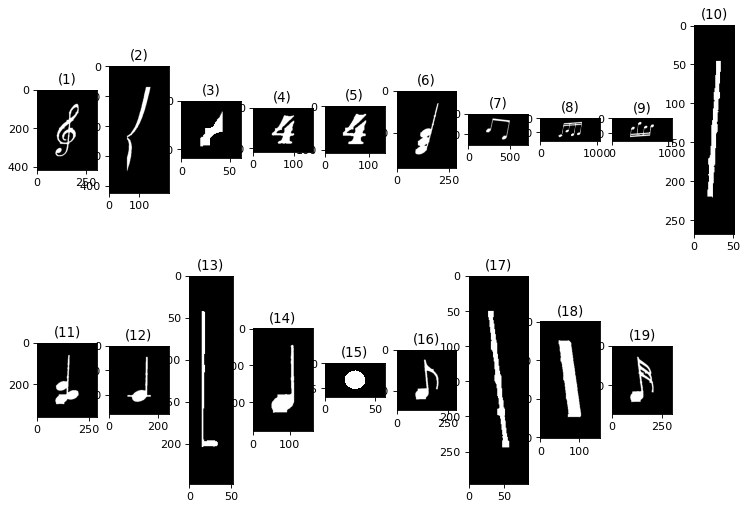

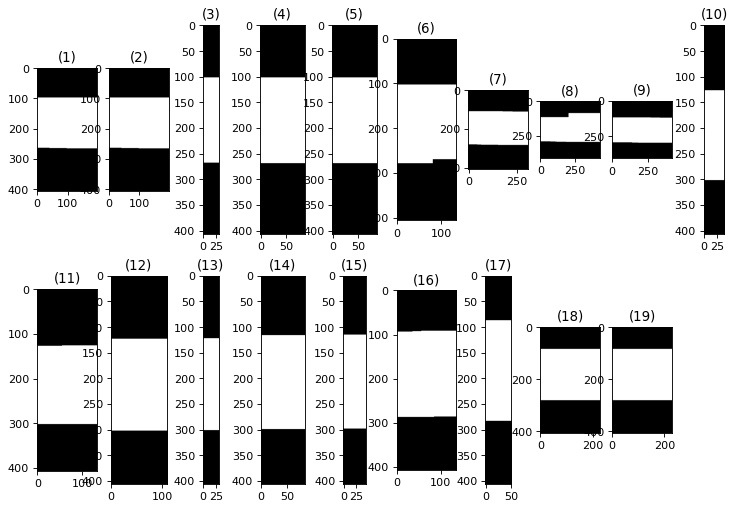

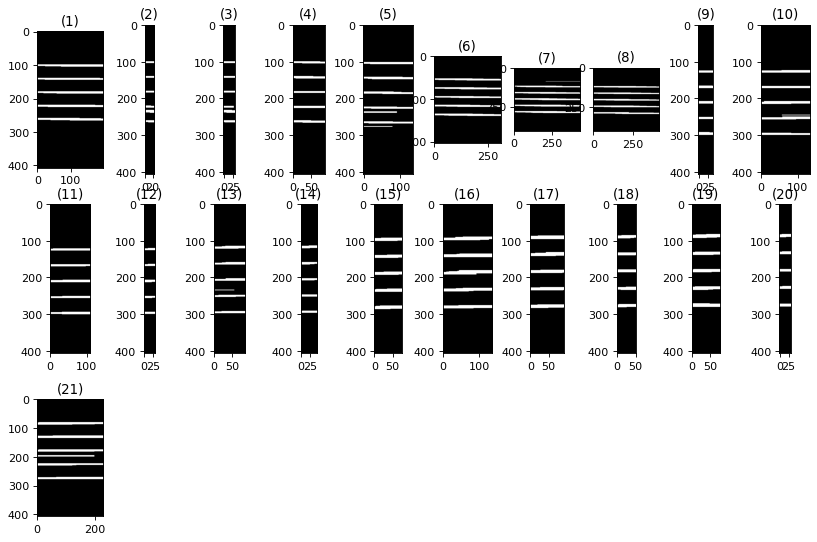

In [469]:
my_show_images(list_of_notes_classification_ready[1], dpi=80, row_max=10)
my_show_images(list_of_notes_staff_lines_classification_ready[1], dpi=80, row_max=10)
my_show_images(list_of_notes_original_thresholded[1], dpi=80, row_max=10)
#my_show_images(list_of_notes_masked[0], dpi=80, row_max=10)

# Detecting note heads

0.6846887001787949


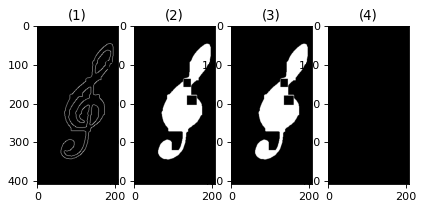

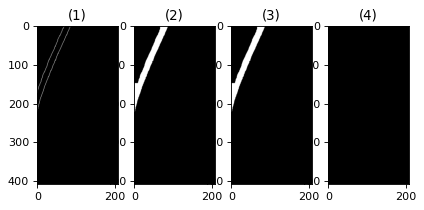

0.33713001447625573


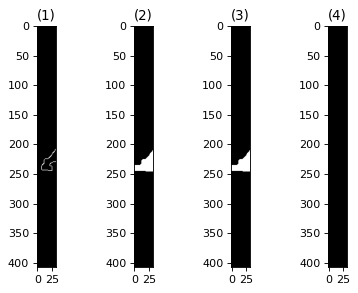

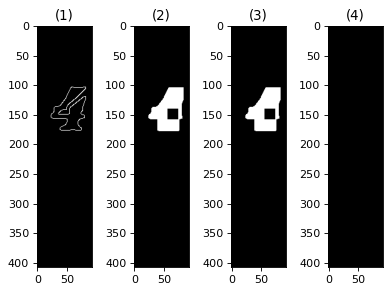

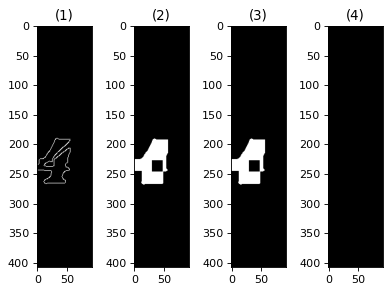

0.5420033762584769
0.5300138810394869
0.5354792672695099
0.5091668334605152


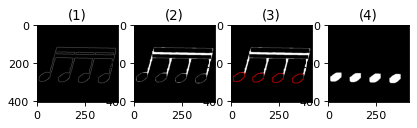

0.5423954931251521


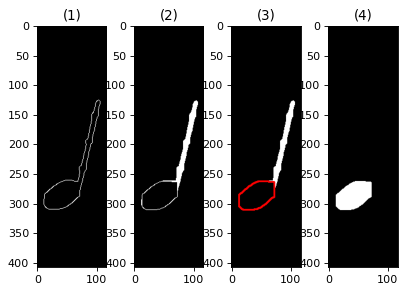

0.6436022390554863


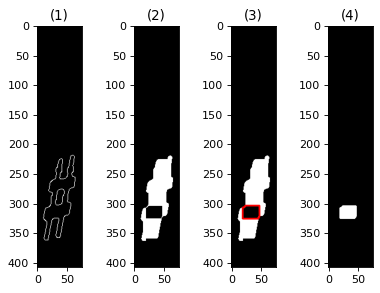

0.5653242007347393


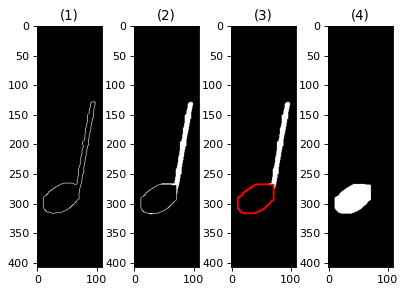

0.5603209001413173


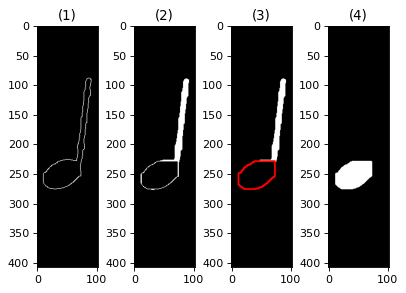

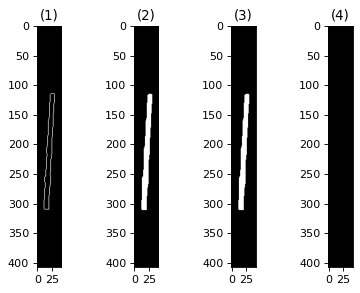

0.6602703003844087


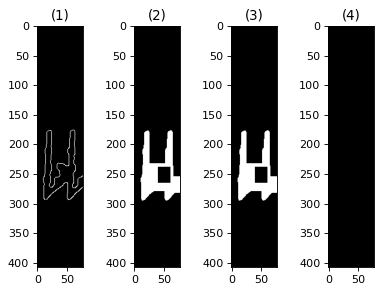

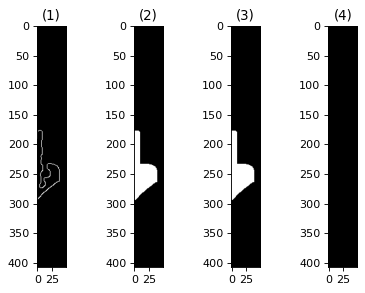

0.594402211253833


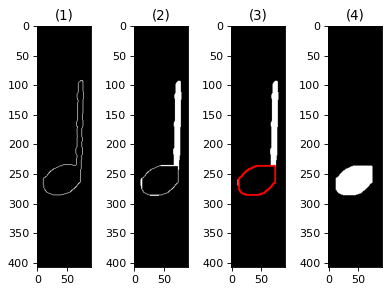

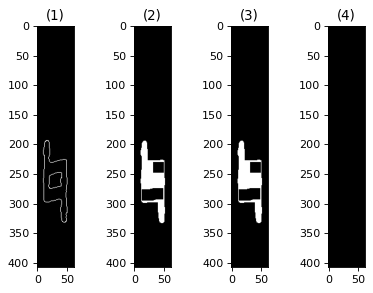

0.6085624243824974


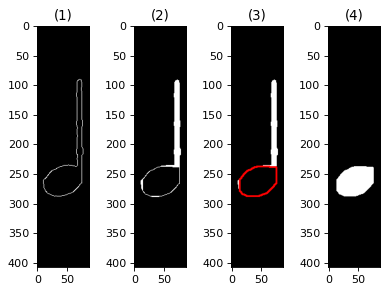

0.62320131219113


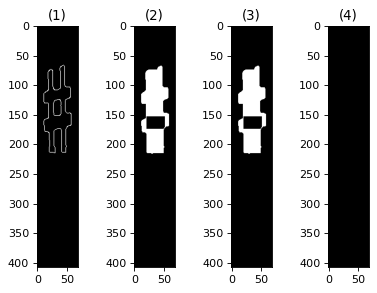

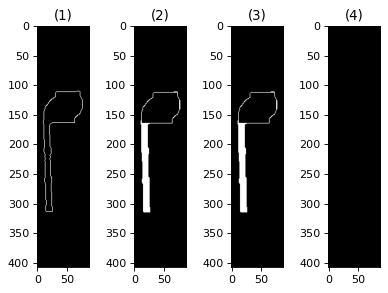

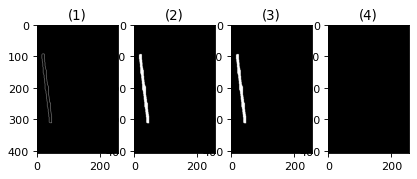

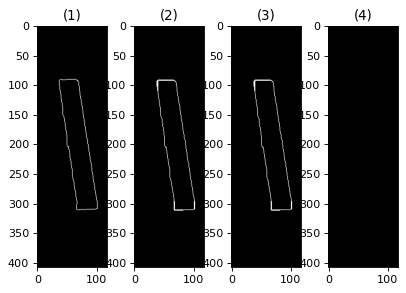

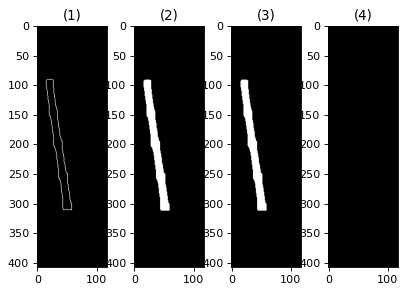

0.6917408326697664


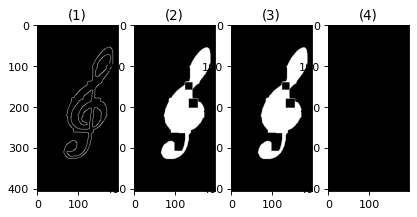

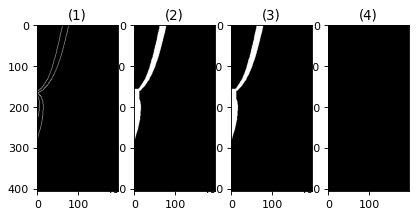

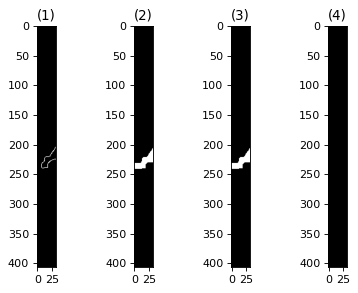

0.5199917179364223


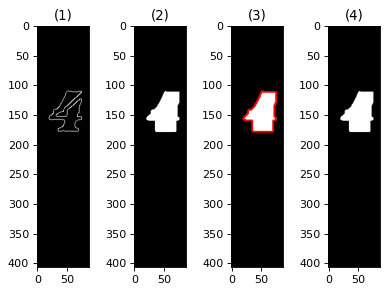

0.5196531197948029


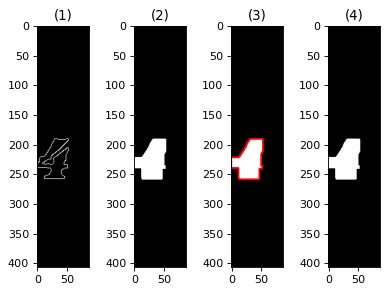

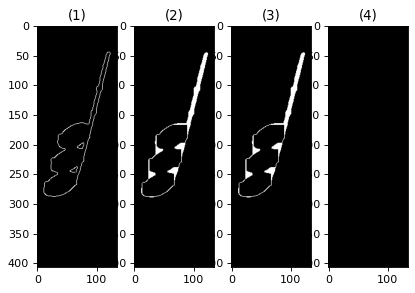

0.531876098129036
0.5043478276540038


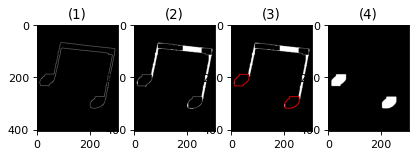

0.5475366729350236
0.5516868290670321
0.5525046750045182
0.5522804576782345


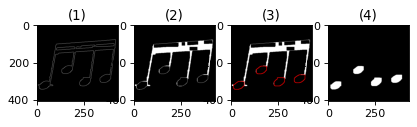

0.6651817828739626
0.543483239097016
0.5576604489759376
0.5640476745887893
0.5832751445225897


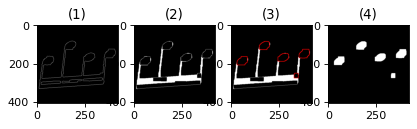

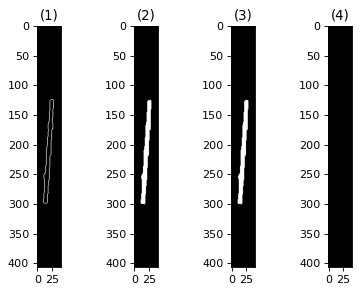

0.5785607794445373


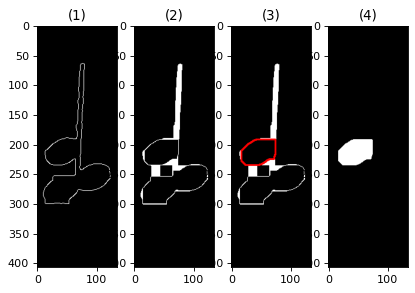

0.5957901934284043


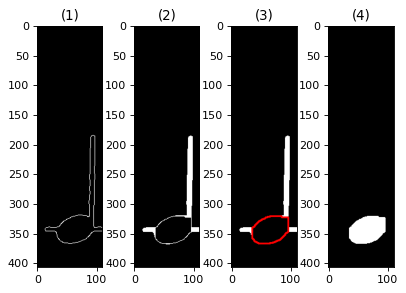

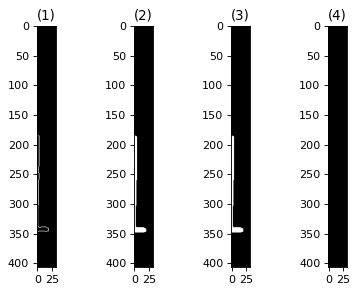

0.5625718209798892


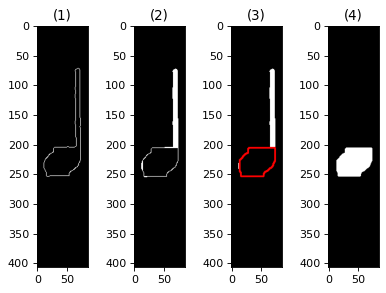

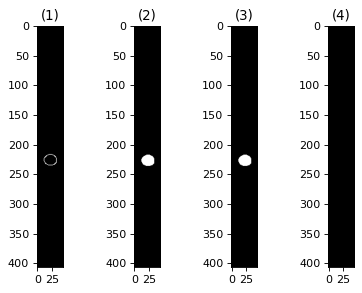

0.6840742968970596


KeyboardInterrupt: 

In [472]:
note_heads_contours = []
i = 0
for lm, dts in zip(list_of_notes_masked, list_of_notes_staff_lines_d_t_classification_ready):
    note_heads_contours.append([])
    for m, dt in zip(lm, dts):
        c = get_note_heads_contours(m, distance_between_staves, staff_thickness)
        note_heads_contours[i].append(c)
    
    i += 1

# getting an output

100%|██████████| 16/16 [00:00<00:00, 2248.73it/s]
get final output
45.5 34
45.75 34
45.75 34
45.75 34
['1', 'f1/4', 'f1/4', 'f1/4', 'f1/4']


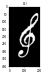

45.25 34
e2/2


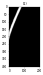

4


4


47.25 34
47.75 34
47.5 34
47.0 34
['0', 'f1/16', 'f1/16', 'f1/16', 'f1/16']


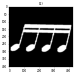

49.25 34
f1/2


#


49.75 34
f1/2


48.25 34
f1/2


&&


49.5 34
f1/2


50.25 34
f1/2


#


51.0 34
e2/2


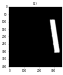

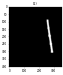

41.75 34
41.75 34
41.75 34
['1', 'f1/4', 'f1/4', 'f1/4']


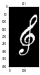

41.5 34
e2/2


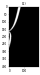

4


4


44.0 34
f1/2


42.75 34
42.75 34
['0', 'f1/8', 'f1/8']


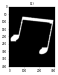

43.25 34
51.5 34
51.5 34
43.75 34
['0', 'f1/16', 'f1/16', 'f1/16', 'f1/16']


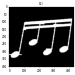

43.75 34
44.25 34
44.0 34
44.25 34
['0', 'f1/16', 'f1/16', 'f1/16', 'f1/16']


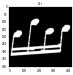

&&


44.5 34
f1/2


45.75 34
f1/4


.


48.25 34
48.5 34
['1', 'f1/4', 'f1/4']


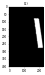

49.5 34
f1/32


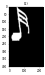

39.25 34
39.25 34
39.25 34
['1', 'f1/4', 'f1/4', 'f1/4']


KeyboardInterrupt: 

In [419]:
list_of_lines_of_classes = []
for line in list_of_notes_classification_ready:
    if len(line)==0:
        continue
    features = extract_features_for_all(line, 'hog')
    list_of_lines_of_classes.append(model.predict(features))

# get final output
print("get final output")
output = []
for i,line in enumerate(list_of_lines_of_classes):
    line_output = []
    for j,obj in enumerate(line):
        obj_output = ""
        
        if(len(note_heads_contours[i][j])>1):
            results , is_cord  = handle_cords_beams(note_heads_contours[i][j],list_of_notes_staff_lines_classification_ready[i][j],distance_between_staves,list_of_notes_classification_ready_contours[i][j])
            
            if(is_cord):
                resultsk= ["1"]
                resultsk.extend(results)
                line_output.append(resultsk)
            else:
                resultsk= ["0"]
                resultsk.extend(results)
                line_output.append(resultsk)
        else:    
            if check_for_char[obj] :
                is_upper = upper[obj]
                obj_output+=get_letter(list_of_notes_staff_lines_classification_ready[i][j],list_of_notes_classification_ready_contours[i][j], distance_between_staves, is_upper)
            obj_output += corresponding_text[obj]
            line_output.append(obj_output)
        
        print(line_output[j])
        my_show_images([list_of_notes_masked[i][j]], dpi=20)
    output.append(line_output)  # ----------------------------- remove reversed if shubra fixes the problem ----------


In [371]:
print(len(list_of_lines_of_classes[0]))
print(len(note_heads_contours[0]))

10
11


In [ ]:
print(binary_lines[0].shape)

In [362]:
def handle_cords_beams(list_of_contours,staff_lines,distance_between_staves,whole_contour):
    x, y, w, h = cv2.boundingRect(whole_contour)
    is_cord= True
    if(w/h>0.7):
        is_cord = False
    #print(is_cord)
    letters = []
    #print(len(list_of_contours))
    for contour in list_of_contours:
        letters.append(get_letter(staff_lines,contour,distance_between_staves,False))
    
    
    nth =8 # determine /8 , /16 , /32
    if is_cord :
        for i, letter in enumerate(letters):
            letters[i] =letter+"/4"
    else : # todo handle if not perfect
        if len(letters) in list([2,4,8]):
            for i, letter in enumerate(letters):
                letters[i] =letter+"/" + str(4*len(letters))
    
    return letters , is_cord

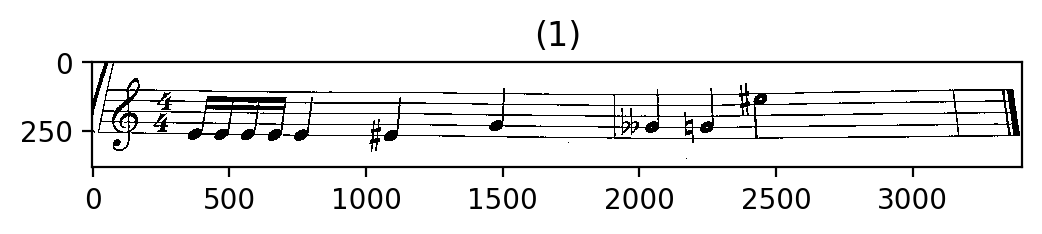

(['c1/16', 'd1/16', 'e1/16', 'g1/16'], False)

In [278]:
my_show_images([binary_lines[kk]], dpi=200)
(['c1/16', 'd1/16', 'e1/16', 'g1/16'], False)


34


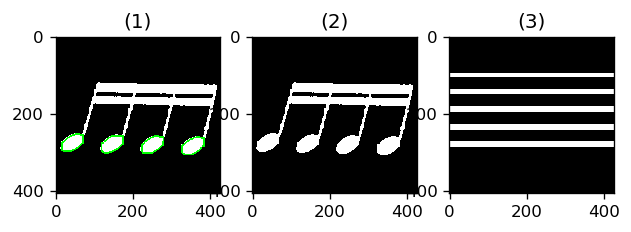

False
c1  23.0
d1  6.0
e1  11.0
f1  33.5
g1  56.0
a1  78.5
b1  101.0
c2  123.5
d2  146.0
e2  168.0
f2  190.0
g2  207.0
a2  224.0
note place : 290.0 note : d1
c1  26.0
d1  9.0
e1  8.0
f1  30.5
g1  53.0
a1  75.5
b1  98.0
c2  120.5
d2  143.0
e2  165.0
f2  187.0
g2  204.0
a2  221.0
note place : 287.0 note : e1
c1  28.0
d1  11.0
e1  6.0
f1  28.5
g1  51.0
a1  73.5
b1  96.0
c2  118.5
d2  141.0
e2  163.0
f2  185.0
g2  202.0
a2  219.0
note place : 285.0 note : e1
c1  31.0
d1  14.0
e1  3.0
f1  25.5
g1  48.0
a1  70.5
b1  93.0
c2  115.5
d2  138.0
e2  160.0
f2  182.0
g2  199.0
a2  216.0
note place : 282.0 note : e1


(['d1/16', 'e1/16', 'e1/16', 'e1/16'], False)

In [165]:
kk=0
ll =15
inn = np.array(list_of_notes_masked[kk][ll])

contours_added =  cv2.drawContours(gray2rgb(inn), note_heads_contours[kk][ll], -1, (0,255,0), 3)

print(distance_between_staves)

my_show_images([contours_added,list_of_notes_masked[kk][ll],list_of_notes_staff_lines_classification_ready[kk][ll]],dpi=120,row_max = 3)
handle_cords_beams(note_heads_contours[kk][ll],list_of_notes_staff_lines_classification_ready[kk][ll],distance_between_staves,list_of_notes_classification_ready_contours[kk][ll])



In [306]:
def fix_output(output):
    new_output = []
    special_chars = ["#","##","&","&&"]
    for i,line in enumerate(output):
        exist_2 =False
        exist_4 =False
        new_line=[]
        for j ,element in enumerate(line) :
            if isinstance(element, list):
                continue
            if element=="4":
                exist_4 = True
                continue
            if element=="2":
                exist_2 = True
                continue
            if element in special_chars:
                if(j==len(line)-1):
                    line[j]=""
                    continue
                line[j+1]=add_special_char(line[j+1],line[j])
                line[j]=""
        
        
        if(exist_2):
            new_line.append("\meter<\"4/2\">")
        elif exist_4:
            new_line.append("\meter<\"4/4\">")
        
        for j, element in enumerate(line) :
            if (not isinstance(element, list)):
                if(element =="4" or element =="2" or len(element)==0):
                    continue
                new_line.append(element)
            else:
                if element[0]=="0" : #is beam
                    new_line.extend(element[1:])
                else:# is cord
                    cord_text = "{"
                    for ck in element[1:-1] :
                        cord_text+= ck+","
                    cord_text += element[-1]+"}"
                    new_line.append(cord_text)
        new_output.append(new_line)
    return new_output

In [303]:
def add_special_char(element,character):
    if isinstance(element, list):
        if(element[0]=="1"):#is a chord
            element[1] = element[1].replace(element[1][0],element[1][0]+character,1)
        return element
    else:
        if len(element)==0:
            return element
        if element[0].isalpha():
            new_element = element.replace(element[0],element[0]+character,1)
            return  new_element
    return element

In [310]:
def get_output_text(new_output):
    finished_output = "{\n"
    if(len(new_output)==1):
        finished_output = ""
        
    for i,line in enumerate(new_output):
        finished_output +="["
        for element in line :
            finished_output += element + " "
        finished_output +="]"
        if(i!=len(new_output)-1):
            finished_output +=",\n"
        
    if(len(new_output)!=1):
        finished_output += "\n}"
    return finished_output

In [311]:

print(get_output_text(fix_output(output)))

{
[f&&1/8 e2/2 f#1/4 e1/8 f1/4 f&&1/2 c1/4 c#1/2 e1/16 c1/16 c1/16 e1/16 e2/32 a1/32 {c1/4,g1/4} d1/2 ],
[e1/1 g1/32 f1/8 {g1/4,g2/4} a1/2 c1/4 c1/8 c2/16 d2/16 e2/16 g2/16 c1/16 c1/16 c1/16 e1/16 c1/32 c1/8 a1/8 e2/32 a1/32 {e1/4,f1/4,e1/4,d1/4} b1/8 ],
[c2/1 f&&1/8 d1/32 c1/8 g1/32 c1/8 e1/8 d1/4 \meter<"4/4"> d1/32 e1/8 d1/8 e1/32 c1/2 e2/32 a1/32 {e1/4,g1/4,a1/4,d1/4} e2/2 d2/8 ]
}


In [281]:
print(isinstance(["e"], list))

cc = [1,2,3,4,5,6]
print(cc[-1])

True
6


In [ ]:
def get_final_output(img):
    #load classifier
    target_img_size = (32, 32)
    with open('svm.pkl', 'rb') as fid:
        model = pickle.load(fid)
        
    #get seperate lines
    print("get seperate lines")
    gray_lines, binary_lines, distance_between_staves, staff_thickness = get_lines(img)
    
    #get shubra lines
    print("get shubra lines")
    potential_lines_of_notes = []
    for i in range(len(gray_lines)):
        potential_lines_of_notes.append(getNotes(gray_lines[i] ,binary_lines[i]))
        
        
    # remove staff lines
    print("remove staff lines")
    list_of_notes = []
    list_of_notes_staff_lines = []
    for i, l in enumerate(potential_lines_of_notes):
        list_of_notes.append([])
        list_of_notes_staff_lines.append([])
        for _note in l:
            if _note.shape[1] >= 20:
                staff_lines_removed, staff_lines = remove_staff_lines(_note, staff_thickness)
                if (staff_lines_removed > 128).any():
                    list_of_notes[i].append(staff_lines_removed)
                    list_of_notes_staff_lines[i].append(staff_lines)
    
    
    #zoom in
    list_of_notes_masked = []
    list_of_notes_classification_ready = [] # zoomed in + padding
    list_of_notes_classification_ready_split_notes_i = [] # VIP when detecting an upside down treple clef
    list_of_notes_staff_lines_classification_ready = []
    list_of_notes_classification_ready_contours = []
    list_of_notes_staff_lines_d_t_classification_ready=[]

    i = 0
    for line_of_notes, line_notes_staff_lines,notes_staff_lines_d_t in zip(list_of_notes, list_of_notes_staff_lines,list_of_notes_staff_lines_d_t):
        list_of_notes_masked.append([])
        list_of_notes_classification_ready.append([])
        list_of_notes_classification_ready_split_notes_i.append([])
        list_of_notes_staff_lines_classification_ready.append([])
        list_of_notes_classification_ready_contours.append([])
        list_of_notes_staff_lines_d_t_classification_ready.append([])
        
        split_i = 0
        for note, sl in zip(line_of_notes, line_notes_staff_lines,):
            masked, notes, staff_lines, notes_contours = zoom_in(note, sl)
            added_notes = 0
            for m, n, s, c , g in zip(masked, notes, staff_lines, notes_contours,notes_staff_lines_d_t):
                if n.shape[1] >= 20 and n.shape[0] >= 20:
                    added_notes += 1
                    
                    list_of_notes_masked[i].append(m)

                    w, h = n.shape[1], n.shape[0]
                    aspect_ratio = n.shape[1]/n.shape[0]
                    n_padding = add_padding(n, ww=int(w*2.5), hh=int(h*1.5), color=0)
                    
                    list_of_notes_classification_ready[i].append(n_padding)
                    
                    list_of_notes_staff_lines_classification_ready[i].append(s)
                    list_of_notes_classification_ready_contours[i].append(c)
                    list_of_notes_staff_lines_d_t_classification_ready[i].append(g)

            if added_notes == 1:
                list_of_notes_classification_ready_split_notes_i[i].append(-1)
            elif added_notes > 1:
                for j in range(added_notes):
                    list_of_notes_classification_ready_split_notes_i[i].append(split_i)
                split_i += 1

        i += 1

    list_of_lines_of_classes = []
    for line in list_of_notes_classification_ready:
        features = extract_features_for_all(line, 'hog')
        list_of_lines_of_classes.append(model.predict(features))
    
    # get final output
    print("get final output")
    output = []
    for i,line in enumerate(list_of_lines_of_classes):
        line_output = []
        for j,obj in enumerate(line):
            obj_output = ""
            if check_for_char[obj] :
                is_upper = upper[obj]
                obj_output+=get_letter(list_of_notes_staff_lines_classification_ready[i][j],list_of_notes_classification_ready_contours[i][j],distance_between_staves,is_upper)
            obj_output += corresponding_text[obj]
            
            line_output.append(obj_output)
        output.append(list(reversed(line_output))) # ----------------------------- remove reversed if shubra fixes the problem ---------------------------
    
    return output

In [ ]:
print(get_fucking_output(img))